## Import Libraries and Define Variables

In [4]:
import os
import csv
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

## Data Manipulation

In [5]:
train_df = pd.read_csv('H2full.csv', dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [6]:
from pandas import DataFrame  

df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
5,2015,27
6,2015,27
7,2015,27
8,2015,27
9,2015,27


In [7]:
# https://datatofish.com/concatenate-values-python/

df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
5        201527
6        201527
7        201527
8        201527
9        201527
10       201527
11       201527
12       201527
13       201527
14       201527
15       201527
16       201527
17       201527
18       201527
19       201527
20       201527
21       201527
22       201527
23       201527
24       201527
25       201527
26       201527
27       201527
28       201527
29       201527
          ...  
79299    201735
79300    201735
79301    201735
79302    201735
79303    201735
79304    201735
79305    201735
79306    201735
79307    201735
79308    201735
79310    201735
79311    201735
79312    201735
79313    201735
79314    201735
79315    201735
79316    201735
79317    201735
79318    201735
79319    201735
79320    201735
79321    201735
79322    201735
79323    201735
79324    201735
79325    201735
79326    201735
79327    201735
79328    201735
79329    201735
Length: 79330, dtype: ob

In [8]:
df2 = DataFrame(c, columns= ['IsCanceled']) 
df2

,IsCanceled
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,0.0
7,1.0
8,1.0
9,1.0


In [9]:
type(df1)

pandas.core.frame.DataFrame

In [10]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'IsCanceled']

In [11]:
df3
df3.sort_values(['FullDate','IsCanceled'], ascending=True)

,FullDate,IsCanceled
0,201527,0.0
6,201527,0.0
10,201527,0.0
11,201527,0.0
12,201527,0.0
13,201527,0.0
15,201527,0.0
17,201527,0.0
18,201527,0.0
22,201527,0.0


In [12]:
df4 = df3.groupby('FullDate').agg(sum)
df4
df4.sort_values(['FullDate'], ascending=True)

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


In [13]:
tseries=df4['IsCanceled']
tseries

FullDate
201527     97.0
201528    153.0
201529    228.0
201530    321.0
201531    159.0
201532    308.0
201533    428.0
201534    191.0
201535    212.0
201536    266.0
201537    331.0
201538    429.0
201539    414.0
201540    324.0
201541    391.0
201542    434.0
201543    150.0
201544    199.0
201545     67.0
201546     81.0
201547     41.0
201548    103.0
201549    169.0
201550    263.0
201551     21.0
201552     43.0
201553    181.0
201601     40.0
201602     35.0
201603     65.0
          ...  
201706    148.0
201707    295.0
201708    277.0
201709    301.0
201710    229.0
201711    353.0
201712    283.0
201713    226.0
201714    432.0
201715    447.0
201716    417.0
201717    568.0
201718    532.0
201719    385.0
201720    666.0
201721    407.0
201722    463.0
201723    456.0
201724    407.0
201725    374.0
201726    391.0
201727    298.0
201728    351.0
201729    222.0
201730    351.0
201731    253.0
201732    269.0
201733    341.0
201734    201.0
201735    129.0
Name: IsCancele

## Plot time series

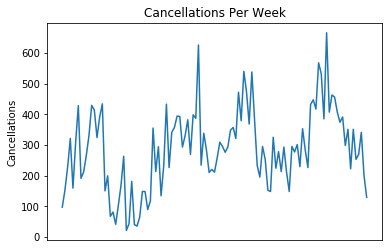

In [14]:
import matplotlib.pyplot as plt
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Cancellations')
plt.title("Cancellations Per Week")
plt.show()

In [15]:
df=pd.DataFrame(tseries)
df

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


In [16]:
df = df[:100]

In [17]:
df

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


## Form dataset matrix

In [18]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
df

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


## Normalize dataset with MinMaxScaler

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.11782946],
       [0.20465116],
       [0.32093023],
       [0.46511628],
       [0.21395349],
       [0.44496124],
       [0.63100775],
       [0.26356589],
       [0.29612403],
       [0.37984496],
       [0.48062016],
       [0.63255814],
       [0.60930233],
       [0.46976744],
       [0.57364341],
       [0.64031008],
       [0.2       ],
       [0.27596899],
       [0.07131783],
       [0.09302326],
       [0.03100775],
       [0.12713178],
       [0.22945736],
       [0.3751938 ],
       [0.        ],
       [0.03410853],
       [0.24806202],
       [0.02945736],
       [0.02170543],
       [0.06821705],
       [0.19689922],
       [0.19689922],
       [0.10542636],
       [0.14883721],
       [0.51782946],
       [0.29767442],
       [0.42325581],
       [0.1751938 ],
       [0.32868217],
       [0.63875969],
       [0.31782946],
       [0.49612403],
       [0.52093023],
       [0.57829457],
       [0.57674419],
       [0.42170543],
       [0.47906977],
       [0.559

## Create training and validation dataset with five previous values

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Training and Validation data partition
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

# Number of previous
previous = 5
X_train, Y_train = create_dataset(train, previous)
X_val, Y_val = create_dataset(val, previous)

In [22]:
X_train

array([[0.11782946, 0.20465116, 0.32093023, 0.46511628, 0.21395349],
       [0.20465116, 0.32093023, 0.46511628, 0.21395349, 0.44496124],
       [0.32093023, 0.46511628, 0.21395349, 0.44496124, 0.63100775],
       [0.46511628, 0.21395349, 0.44496124, 0.63100775, 0.26356589],
       [0.21395349, 0.44496124, 0.63100775, 0.26356589, 0.29612403],
       [0.44496124, 0.63100775, 0.26356589, 0.29612403, 0.37984496],
       [0.63100775, 0.26356589, 0.29612403, 0.37984496, 0.48062016],
       [0.26356589, 0.29612403, 0.37984496, 0.48062016, 0.63255814],
       [0.29612403, 0.37984496, 0.48062016, 0.63255814, 0.60930233],
       [0.37984496, 0.48062016, 0.63255814, 0.60930233, 0.46976744],
       [0.48062016, 0.63255814, 0.60930233, 0.46976744, 0.57364341],
       [0.63255814, 0.60930233, 0.46976744, 0.57364341, 0.64031008],
       [0.60930233, 0.46976744, 0.57364341, 0.64031008, 0.2       ],
       [0.46976744, 0.57364341, 0.64031008, 0.2       , 0.27596899],
       [0.57364341, 0.64031008, 0.

In [23]:
Y_train

array([0.44496124, 0.63100775, 0.26356589, 0.29612403, 0.37984496,
       0.48062016, 0.63255814, 0.60930233, 0.46976744, 0.57364341,
       0.64031008, 0.2       , 0.27596899, 0.07131783, 0.09302326,
       0.03100775, 0.12713178, 0.22945736, 0.3751938 , 0.        ,
       0.03410853, 0.24806202, 0.02945736, 0.02170543, 0.06821705,
       0.19689922, 0.19689922, 0.10542636, 0.14883721, 0.51782946,
       0.29767442, 0.42325581, 0.1751938 , 0.32868217, 0.63875969,
       0.31782946, 0.49612403, 0.52093023, 0.57829457, 0.57674419,
       0.42170543, 0.47906977, 0.55968992, 0.38449612, 0.58449612,
       0.56744186, 0.9379845 , 0.33023256, 0.49147287, 0.40620155,
       0.29302326, 0.30852713, 0.29457364, 0.36589147, 0.44651163,
       0.4248062 , 0.39534884, 0.42170543, 0.50697674, 0.52093023,
       0.46511628, 0.69922481, 0.55503876, 0.80465116, 0.70077519,
       0.5379845 , 0.80155039, 0.5627907 , 0.32868217, 0.26976744,
       0.4248062 , 0.35968992, 0.20310078, 0.19689922])

## Reshape input to be [samples, time steps, features]

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

## Generate LSTM network

In [24]:
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, previous)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)

Train on 74 samples
Epoch 1/20
74/74 - 1s - loss: 0.1340
Epoch 2/20
74/74 - 0s - loss: 0.0694
Epoch 3/20
74/74 - 0s - loss: 0.0383
Epoch 4/20
74/74 - 0s - loss: 0.0320
Epoch 5/20
74/74 - 0s - loss: 0.0308
Epoch 6/20
74/74 - 0s - loss: 0.0305
Epoch 7/20
74/74 - 0s - loss: 0.0305
Epoch 8/20
74/74 - 0s - loss: 0.0302
Epoch 9/20
74/74 - 0s - loss: 0.0297
Epoch 10/20
74/74 - 0s - loss: 0.0295
Epoch 11/20
74/74 - 0s - loss: 0.0294
Epoch 12/20
74/74 - 0s - loss: 0.0292
Epoch 13/20
74/74 - 0s - loss: 0.0288
Epoch 14/20
74/74 - 0s - loss: 0.0287
Epoch 15/20
74/74 - 0s - loss: 0.0283
Epoch 16/20
74/74 - 0s - loss: 0.0280
Epoch 17/20
74/74 - 0s - loss: 0.0281
Epoch 18/20
74/74 - 0s - loss: 0.0280
Epoch 19/20
74/74 - 0s - loss: 0.0278
Epoch 20/20
74/74 - 0s - loss: 0.0272


## Generate predictions

In [ ]:
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [26]:
trainpred

array([[0.32006207],
       [0.36352956],
       [0.42995065],
       [0.39102295],
       [0.38770908],
       [0.4149856 ],
       [0.42176554],
       [0.42664212],
       [0.46703687],
       [0.4762663 ],
       [0.505759  ],
       [0.5270717 ],
       [0.43769228],
       [0.42613122],
       [0.37432826],
       [0.30873954],
       [0.23515621],
       [0.2193269 ],
       [0.21368292],
       [0.25484776],
       [0.24290752],
       [0.239329  ],
       [0.25985968],
       [0.2312202 ],
       [0.17866604],
       [0.19577274],
       [0.21496794],
       [0.20862834],
       [0.21839587],
       [0.23583898],
       [0.29514146],
       [0.31570756],
       [0.34043637],
       [0.35626796],
       [0.37732017],
       [0.3978246 ],
       [0.3830704 ],
       [0.4035824 ],
       [0.45450002],
       [0.4805888 ],
       [0.47654802],
       [0.47680798],
       [0.48206195],
       [0.4915666 ],
       [0.45423815],
       [0.46921107],
       [0.48778075],
       [0.551

In [27]:
valpred

array([[0.37811893],
       [0.35576797],
       [0.36414087],
       [0.3821337 ],
       [0.38001925],
       [0.38401696],
       [0.4279594 ],
       [0.4238162 ],
       [0.40517408],
       [0.4386497 ],
       [0.4878528 ],
       [0.48723063],
       [0.5445712 ],
       [0.588608  ]], dtype=float32)

## Convert predictions back to normal values

In [ ]:
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [29]:
import math
from sklearn.metrics import mean_squared_error

Train Score: 105.87 RMSE
Validation Score: 106.90 RMSE


## calculate RMSE

In [ ]:
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

## Train predictions

In [ ]:
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

## Validation predictions

In [ ]:
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(previous*2)+1:len(df)-1, :] = valpred

## Plot all predictions

In [ ]:
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(trainpredPlot)
valpred, =plt.plot(valpredPlot)
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Cancellations Per Week")
plt.show()

In [33]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [34]:
Y_val

0     148.0
1     295.0
2     277.0
3     301.0
4     229.0
5     353.0
6     283.0
7     226.0
8     432.0
9     447.0
10    417.0
11    568.0
12    532.0
13    385.0
dtype: float64

In [35]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [36]:
predictions

0     264.886719
1     250.470337
2     255.870865
3     267.476227
4     266.112427
5     268.690948
6     297.033813
7     294.361450
8     282.337280
9     303.929077
10    335.665070
11    335.263733
12    372.248444
13    400.652191
dtype: float32

In [37]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [38]:
mda(Y_val, predictions)

0.8571428571428571

## Calculate mean squared error

### Useful reference: https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 106.900011


In [40]:
forecast_error = (predictions-Y_val)
forecast_error

0     116.886719
1     -44.529663
2     -21.129135
3     -33.523773
4      37.112427
5     -84.309052
6      14.033813
7      68.361450
8    -149.662720
9    -143.070923
10    -81.334930
11   -232.736267
12   -159.751556
13     15.652191
dtype: float64

In [41]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-49.857244219098774

In [42]:
X_train

array([[[0.11782946, 0.20465116, 0.32093023, 0.46511628, 0.21395349]],

       [[0.20465116, 0.32093023, 0.46511628, 0.21395349, 0.44496124]],

       [[0.32093023, 0.46511628, 0.21395349, 0.44496124, 0.63100775]],

       [[0.46511628, 0.21395349, 0.44496124, 0.63100775, 0.26356589]],

       [[0.21395349, 0.44496124, 0.63100775, 0.26356589, 0.29612403]],

       [[0.44496124, 0.63100775, 0.26356589, 0.29612403, 0.37984496]],

       [[0.63100775, 0.26356589, 0.29612403, 0.37984496, 0.48062016]],

       [[0.26356589, 0.29612403, 0.37984496, 0.48062016, 0.63255814]],

       [[0.29612403, 0.37984496, 0.48062016, 0.63255814, 0.60930233]],

       [[0.37984496, 0.48062016, 0.63255814, 0.60930233, 0.46976744]],

       [[0.48062016, 0.63255814, 0.60930233, 0.46976744, 0.57364341]],

       [[0.63255814, 0.60930233, 0.46976744, 0.57364341, 0.64031008]],

       [[0.60930233, 0.46976744, 0.57364341, 0.64031008, 0.2       ]],

       [[0.46976744, 0.57364341, 0.64031008, 0.2       , 0.27596

## Test (unseen) predictions: (t) and (t-5)

In [ ]:
Xnew = np.array([[407,463,456,407,374],[463,456,407,374,391],[456,407,374,391,298],[407,374,391,298,351],[374,391,298,351,222],[391,298,351,222,351],[298,351,222,351,253],[351,222,351,253,269],[222,351,253,269,341],[351,253,269,341,201]])

In [44]:
Xnew

array([[407, 463, 456, 407, 374],
       [463, 456, 407, 374, 391],
       [456, 407, 374, 391, 298],
       [407, 374, 391, 298, 351],
       [374, 391, 298, 351, 222],
       [391, 298, 351, 222, 351],
       [298, 351, 222, 351, 253],
       [351, 222, 351, 253, 269],
       [222, 351, 253, 269, 341],
       [351, 253, 269, 341, 201]])

In [45]:
Xnew = scaler.fit_transform(Xnew)
Xnew
Xnewformat = np.reshape(Xnew, (Xnew.shape[0], 1, Xnew.shape[1]))
ynew=model.predict(Xnewformat)

In [46]:
Xnew.shape

(10, 5)

In [47]:
ynew

array([[0.6686178 ],
       [0.67612565],
       [0.57454383],
       [0.571032  ],
       [0.43751308],
       [0.45701286],
       [0.39165166],
       [0.35326397],
       [0.3444598 ],
       [0.30862314]], dtype=float32)

In [48]:
type(ynew)

numpy.ndarray

In [49]:
ynew.shape

(10, 1)

In [50]:
actual = np.array([[391,298,351,222,351,253,269,341,201,129]])

In [51]:
actual=actual.reshape(10,-1)
actual.shape

(10, 1)

In [52]:
actual

array([[391],
       [298],
       [351],
       [222],
       [351],
       [253],
       [269],
       [341],
       [201],
       [129]])

In [53]:
ynew=ynew.reshape(-1)
actual=actual.reshape(-1)
actualpd=pd.Series(actual)

In [54]:
np.min(df)

0.0

In [55]:
ynew

array([0.6686178 , 0.67612565, 0.57454383, 0.571032  , 0.43751308,
       0.45701286, 0.39165166, 0.35326397, 0.3444598 , 0.30862314],
      dtype=float32)

In [56]:
maxcancel=np.max(tseries)

In [57]:
mincancel=np.min(tseries)

In [58]:
ynew = ynew * np.abs(maxcancel-mincancel) + np.min(tseries)
ynewpd=pd.Series(ynew)

In [59]:
actualpd

0    391
1    298
2    351
3    222
4    351
5    253
6    269
7    341
8    201
9    129
dtype: int64

In [60]:
ynewpd

0    452.258484
1    457.101044
2    391.580780
3    389.315643
4    303.195953
5    315.773285
6    273.615326
7    248.855270
8    243.176575
9    220.061920
dtype: float32

In [61]:
mda(actualpd, ynewpd)

0.8

In [62]:
mse = mean_squared_error(actualpd, ynewpd)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 91.387017


In [63]:
forecast_error = (ynewpd-actualpd)
forecast_error

0     61.258484
1    159.101044
2     40.580780
3    167.315643
4    -47.804047
5     62.773285
6      4.615326
7    -92.144730
8     42.176575
9     91.061920
dtype: float64

In [64]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

48.893428039550784

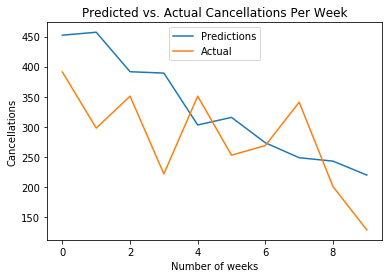

In [65]:
predictons, =plt.plot(ynewpd, label='Predictions')
actual, =plt.plot(actualpd, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Cancellations Per Week")
plt.legend(loc = 'upper center')
plt.show()